#Klasifikasi Opini Pengguna Media Sosial Twitter Terhadap Jasa Ekspedisi JNE Dengan Metode Naive Bayes

Dataset yang digunakan dalam analisis ini merupakan data postingan yang mention akun Twitter JNE dengan 2 label (positif & negatif) yang telah Saya simpan dalam format CSV.


# 1. Import Library & Dependencies

In [ ]:
pip install sastrawi

In [ ]:
import nltk
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import re
import itertools
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Import data tweet JNE

In [ ]:
sheet_id = "18pD2tgC7xc9FdY1nvvCo_y1ko6Ihq6kl9xs50qpTo6w"
sheet_name = "data_tweet_JNE"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df_tweets = pd.read_csv(url,index_col=[0])
df_tweets.isna().sum()

tweet         0  
label         0  
Unnamed: 3    550
Unnamed: 4    550
Unnamed: 5    550
dtype: int64

In [ ]:
df_tweets

,tweet,label,Unnamed: 3,Unnamed: 4,Unnamed: 5
no,,,,,
1,Terima kasih untuk semuanya JNE atas pelayannnya.,Positif,NaN,NaN,NaN
2,"Mas JNE nya sweet banget nganter paketan malam, hujan deres begini plus ngabarin juga kalo agak telat sampainya karena ngeyup dulu.",Positif,NaN,NaN,NaN
3,"Rejeki hari ini adalah ngirim barang pake JNE YES gratis. Kata mbak-nya cuma sampe besok dan jabodetabek only, gaes. Mayan banget. #TerimaKasihJNE",Positif,NaN,NaN,NaN
4,udah sampe min kirimannya alhamdulilah terimakasih JNE,Positif,NaN,NaN,NaN
5,Akhirnya aku sms alamat yg benernya dan tanya kekurangannya berapa dan harus transfer kemana #terimakasihJNE,Positif,NaN,NaN,NaN
...,...,...,...,...,...
546,Sampai kapan ini dipending.. barang itu mau dipake.. ini kesekian kalinya JNE ngga tepat waktu kirim barang dengan alasan KLISE yng sama,Negatif,NaN,NaN,NaN
547,"Dah lambat paketnya baru kemarin nyampenya, tolong diperbaiki yah daripada pelanggan semua beralih ekspedisi yang cepat tanggap dan responnya bagus",Negatif,NaN,NaN,NaN
548,"selain ngilangin, kurirnya judes",Negatif,NaN,NaN,NaN


# 3. Delete duplicate & unused column 

In [ ]:
df_tweets.drop(df_tweets.filter(regex="Unname"),axis=1, inplace=True)
df_tweets

,tweet,label
no,,
1,Terima kasih untuk semuanya JNE atas pelayannnya.,Positif
2,"Mas JNE nya sweet banget nganter paketan malam, hujan deres begini plus ngabarin juga kalo agak telat sampainya karena ngeyup dulu.",Positif
3,"Rejeki hari ini adalah ngirim barang pake JNE YES gratis. Kata mbak-nya cuma sampe besok dan jabodetabek only, gaes. Mayan banget. #TerimaKasihJNE",Positif
4,udah sampe min kirimannya alhamdulilah terimakasih JNE,Positif
5,Akhirnya aku sms alamat yg benernya dan tanya kekurangannya berapa dan harus transfer kemana #terimakasihJNE,Positif
...,...,...
546,Sampai kapan ini dipending.. barang itu mau dipake.. ini kesekian kalinya JNE ngga tepat waktu kirim barang dengan alasan KLISE yng sama,Negatif
547,"Dah lambat paketnya baru kemarin nyampenya, tolong diperbaiki yah daripada pelanggan semua beralih ekspedisi yang cepat tanggap dan responnya bagus",Negatif
548,"selain ngilangin, kurirnya judes",Negatif


# 4. Create preprocessing function

In [ ]:
sw = stopwords.words('indonesian')

In [ ]:
factory = StopWordRemoverFactory()
 
def remove_tweet_special(text):
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"").replace('USERNAME', "").replace('-', " ").replace(',', " ")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text.replace("http://", " ").replace("https://", " ")
                
def remove_number(text):
    return  re.sub(r"\d+", "", text)
 
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
 
def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)
    
def remove_whitespace_LT(text):
    return text.strip()
 
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)
 
def word_tokenize_wrapper(text):
    return word_tokenize(text)
 
def preprocess_tweet(tweet):
    tweet.lower()
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    output = stemmer.stem(tweet) 
    return output

In [ ]:
print(sw)

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan'

# 5. Text preprocessing

In [ ]:
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_tweet_special)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_number)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_punctuation)
df_tweets['tweet'] = df_tweets['tweet'].apply(stopwords)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_whitespace_LT)
df_tweets['tweet'] = df_tweets['tweet'].apply(remove_whitespace_multiple)

In [ ]:
df_tweets

,tweet,label
no,,
1,terima kasih jne pelayannnya,Positif
2,mas jne nya sweet banget nganter paketan malam hujan deres plus ngabarin kalo telat sampainya ngeyup,Positif
3,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget,Positif
4,udah sampe min kirimannya alhamdulilah terimakasih jne,Positif
5,sms alamat yg benernya kekurangannya transfer kemana,Positif
...,...,...
546,dipending barang dipake kesekian kalinya jne ngga kirim barang alasan klise yng,Negatif
547,dah lambat paketnya kemarin nyampenya tolong diperbaiki yah pelanggan beralih ekspedisi cepat tanggap responnya bagus,Negatif
548,ngilangin kurirnya judes,Negatif


# 6. Stemming data tweet dengan library Sastrawi
Untuk menghemat waktu dalam proses stemming data menggunakan sastrawi, maka saya export kedalam format csv untuk digunakan kembali tanpa harus melakukan stemming ulang.

In [ ]:
df_tweets['tweet_norm'] = df_tweets['tweet'].apply(preprocess_tweet)
df_tweets.to_csv('tweets_preprocessed.csv')

# 7. Load preprocessed data tweet

In [ ]:
df_tweets = pd.read_csv('tweets_preprocessed.csv')
df_tweets.drop(df_tweets.filter(regex="Unname"),axis=1, inplace=True)

In [ ]:
df_tweets

,no,tweet,label,tweet_norm
0,1,terima kasih jne pelayannnya,Positif,terima kasih jne pelayannnya
1,2,mas jne nya sweet banget nganter paketan malam hujan deres plus ngabarin kalo telat sampainya ngeyup,Positif,mas jne nya sweet banget nganter paket malam hujan deres plus ngabarin kalo telat sampai ngeyup
2,3,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget,Positif,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget
3,4,udah sampe min kirimannya alhamdulilah terimakasih jne,Positif,udah sampe min kirim alhamdulilah terimakasih jne
4,5,sms alamat yg benernya kekurangannya transfer kemana,Positif,sms alamat yg benernya kurang transfer mana
...,...,...,...,...
545,546,dipending barang dipake kesekian kalinya jne ngga kirim barang alasan klise yng,Negatif,pending barang dipake sekian kali jne ngga kirim barang alas klise yng
546,547,dah lambat paketnya kemarin nyampenya tolong diperbaiki yah pelanggan beralih ekspedisi cepat tanggap responnya bagus,Negatif,dah lambat paket kemarin nyampenya tolong baik yah langgan alih ekspedisi cepat tanggap responnya bagus
547,548,ngilangin kurirnya judes,Negatif,ngilangin kurir judes
548,549,pelayanan jne parah paketnya gak pikir pakai jasa jne tolong koreksi pelayanan jne,Negatif,layan jne parah paket gak pikir pakai jasa jne tolong koreksi layan jne


# 8. Create freqDist_wrapper to counting frequency from each word

In [ ]:
def freqDist_wrapper(text):
    return FreqDist(text)

df_tweets['tweet_tokens'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)

df_tweets['tweet_tokens_fdist'] = df_tweets['tweet_tokens'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
print(df_tweets['tweet_tokens_fdist'].head().apply(lambda x : x.most_common()))

Frequency Tokens : 

0    [(terima, 1), (kasih, 1), (jne, 1), (pelayannnya, 1)]                                                                                                                                            
1    [(mas, 1), (jne, 1), (nya, 1), (sweet, 1), (banget, 1), (nganter, 1), (paket, 1), (malam, 1), (hujan, 1), (deres, 1), (plus, 1), (ngabarin, 1), (kalo, 1), (telat, 1), (sampai, 1), (ngeyup, 1)] 
2    [(rejeki, 1), (ngirim, 1), (barang, 1), (pake, 1), (jne, 1), (yes, 1), (gratis, 1), (mbak, 1), (nya, 1), (sampe, 1), (besok, 1), (jabodetabek, 1), (only, 1), (gaes, 1), (mayan, 1), (banget, 1)]
3    [(udah, 1), (sampe, 1), (min, 1), (kirim, 1), (alhamdulilah, 1), (terimakasih, 1), (jne, 1)]                                                                                                     
4    [(sms, 1), (alamat, 1), (yg, 1), (benernya, 1), (kurang, 1), (transfer, 1), (mana, 1)]                                                                                            

In [ ]:
df_tweets.head()

,no,tweet,label,tweet_norm,tweet_tokens,tweet_tokens_fdist
0,1,terima kasih jne pelayannnya,Positif,terima kasih jne pelayannnya,"[terima, kasih, jne, pelayannnya]","{'terima': 1, 'kasih': 1, 'jne': 1, 'pelayannnya': 1}"
1,2,mas jne nya sweet banget nganter paketan malam hujan deres plus ngabarin kalo telat sampainya ngeyup,Positif,mas jne nya sweet banget nganter paket malam hujan deres plus ngabarin kalo telat sampai ngeyup,"[mas, jne, nya, sweet, banget, nganter, paket, malam, hujan, deres, plus, ngabarin, kalo, telat, sampai, ngeyup]","{'mas': 1, 'jne': 1, 'nya': 1, 'sweet': 1, 'banget': 1, 'nganter': 1, 'paket': 1, 'malam': 1, 'hujan': 1, 'deres': 1, 'plus': 1, 'ngabarin': 1, 'kalo': 1, 'telat': 1, 'sampai': 1, 'ngeyup': 1}"
2,3,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget,Positif,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget,"[rejeki, ngirim, barang, pake, jne, yes, gratis, mbak, nya, sampe, besok, jabodetabek, only, gaes, mayan, banget]","{'rejeki': 1, 'ngirim': 1, 'barang': 1, 'pake': 1, 'jne': 1, 'yes': 1, 'gratis': 1, 'mbak': 1, 'nya': 1, 'sampe': 1, 'besok': 1, 'jabodetabek': 1, 'only': 1, 'gaes': 1, 'mayan': 1, 'banget': 1}"
3,4,udah sampe min kirimannya alhamdulilah terimakasih jne,Positif,udah sampe min kirim alhamdulilah terimakasih jne,"[udah, sampe, min, kirim, alhamdulilah, terimakasih, jne]","{'udah': 1, 'sampe': 1, 'min': 1, 'kirim': 1, 'alhamdulilah': 1, 'terimakasih': 1, 'jne': 1}"
4,5,sms alamat yg benernya kekurangannya transfer kemana,Positif,sms alamat yg benernya kurang transfer mana,"[sms, alamat, yg, benernya, kurang, transfer, mana]","{'sms': 1, 'alamat': 1, 'yg': 1, 'benernya': 1, 'kurang': 1, 'transfer': 1, 'mana': 1}"


# 9. Create Clean_length function & convert_to_string
Bertujuan untuk menghapus kata yang kurang dari 3 karakter

In [ ]:
def Clean_length(token):
    return [i for i in token if len(i) > 3]
def convert_to_string(listReview):
    return ' '.join(listReview)

df_tweets['tweet_norm2'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(Clean_length)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(convert_to_string)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(stopwords)

# 10. Result of preprocessed data tweet
* **label** -> Positif / Negatif
* **tweet** -> rejeki ngirim barang pakai jne yes gratis mbak...
* **tweet_norm** -> kata yang sudah di normalisasi/preprocess
* **tweet_tokens** -> memisahkan setiap kata kemudian diubah menjadi list sebagai processing text nanti
* **tweet_tokens_fdist** -> mencari frekuensi dari setiap kata
* **tweet_norm2** -> Kata-kata yang sudah tidak memiliki kata kurang dari 4 karakter
* **label_id** -> Label yang sudah diubah menjadi numerical

In [ ]:
df_tweets

,no,tweet,label,tweet_norm,tweet_tokens,tweet_tokens_fdist,tweet_norm2
0,1,terima kasih jne pelayannnya,Positif,terima kasih jne pelayannnya,"[terima, kasih, jne, pelayannnya]","{'terima': 1, 'kasih': 1, 'jne': 1, 'pelayannnya': 1}",terima kasih pelayannnya
1,2,mas jne nya sweet banget nganter paketan malam hujan deres plus ngabarin kalo telat sampainya ngeyup,Positif,mas jne nya sweet banget nganter paket malam hujan deres plus ngabarin kalo telat sampai ngeyup,"[mas, jne, nya, sweet, banget, nganter, paket, malam, hujan, deres, plus, ngabarin, kalo, telat, sampai, ngeyup]","{'mas': 1, 'jne': 1, 'nya': 1, 'sweet': 1, 'banget': 1, 'nganter': 1, 'paket': 1, 'malam': 1, 'hujan': 1, 'deres': 1, 'plus': 1, 'ngabarin': 1, 'kalo': 1, 'telat': 1, 'sampai': 1, 'ngeyup': 1}",sweet banget nganter paket malam hujan deres plus ngabarin kalo telat ngeyup
2,3,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget,Positif,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget,"[rejeki, ngirim, barang, pake, jne, yes, gratis, mbak, nya, sampe, besok, jabodetabek, only, gaes, mayan, banget]","{'rejeki': 1, 'ngirim': 1, 'barang': 1, 'pake': 1, 'jne': 1, 'yes': 1, 'gratis': 1, 'mbak': 1, 'nya': 1, 'sampe': 1, 'besok': 1, 'jabodetabek': 1, 'only': 1, 'gaes': 1, 'mayan': 1, 'banget': 1}",rejeki ngirim barang pake gratis mbak sampe besok jabodetabek only gaes mayan banget
3,4,udah sampe min kirimannya alhamdulilah terimakasih jne,Positif,udah sampe min kirim alhamdulilah terimakasih jne,"[udah, sampe, min, kirim, alhamdulilah, terimakasih, jne]","{'udah': 1, 'sampe': 1, 'min': 1, 'kirim': 1, 'alhamdulilah': 1, 'terimakasih': 1, 'jne': 1}",udah sampe kirim alhamdulilah terimakasih
4,5,sms alamat yg benernya kekurangannya transfer kemana,Positif,sms alamat yg benernya kurang transfer mana,"[sms, alamat, yg, benernya, kurang, transfer, mana]","{'sms': 1, 'alamat': 1, 'yg': 1, 'benernya': 1, 'kurang': 1, 'transfer': 1, 'mana': 1}",alamat benernya transfer
...,...,...,...,...,...,...,...
545,546,dipending barang dipake kesekian kalinya jne ngga kirim barang alasan klise yng,Negatif,pending barang dipake sekian kali jne ngga kirim barang alas klise yng,"[pending, barang, dipake, sekian, kali, jne, ngga, kirim, barang, alas, klise, yng]","{'pending': 1, 'barang': 2, 'dipake': 1, 'sekian': 1, 'kali': 1, 'jne': 1, 'ngga': 1, 'kirim': 1, 'alas': 1, 'klise': 1, 'yng': 1}",pending barang dipake sekian kali ngga kirim barang alas klise
546,547,dah lambat paketnya kemarin nyampenya tolong diperbaiki yah pelanggan beralih ekspedisi cepat tanggap responnya bagus,Negatif,dah lambat paket kemarin nyampenya tolong baik yah langgan alih ekspedisi cepat tanggap responnya bagus,"[dah, lambat, paket, kemarin, nyampenya, tolong, baik, yah, langgan, alih, ekspedisi, cepat, tanggap, responnya, bagus]","{'dah': 1, 'lambat': 1, 'paket': 1, 'kemarin': 1, 'nyampenya': 1, 'tolong': 1, 'baik': 1, 'yah': 1, 'langgan': 1, 'alih': 1, 'ekspedisi': 1, 'cepat': 1, 'tanggap': 1, 'responnya': 1, 'bagus': 1}",lambat paket kemarin nyampenya tolong langgan alih ekspedisi cepat tanggap responnya bagus
547,548,ngilangin kurirnya judes,Negatif,ngilangin kurir judes,"[ngilangin, kurir, judes]","{'ngilangin': 1, 'kurir': 1, 'judes': 1}",ngilangin kurir judes
548,549,pelayanan jne parah paketnya gak pikir pakai jasa jne tolong koreksi pelayanan jne,Negatif,layan jne parah paket gak pikir pakai jasa jne tolong koreksi layan jne,"[layan, jne, parah, paket, gak, pikir, pakai, jasa, jne, tolong, koreksi, layan, jne]","{'layan': 2, 'jne': 3, 'parah': 1, 'paket': 1, 'gak': 1, 'pikir': 1, 'pakai': 1, 'jasa': 1, 'tolong': 1, 'koreksi': 1}",layan parah paket pikir pakai jasa tolong koreksi layan


# 11. Count unique words in data tweet

In [ ]:
unique_string = set()
for x in df_tweets['tweet_norm2']:
    for y in x.split():
        unique_string.add(y)
        
len(unique_string)

1195

In [ ]:
unique_string

{'rela',
 'kompeten',
 'perkembanganhari',
 'lupa',
 'kurir',
 'bnrnyeee',
 'kenapabarang',
 'rumpi',
 'mane',
 'duluan',
 'realpict',
 'ditingkatin',
 'januari',
 'nyamperin',
 'tanggal',
 'keluh',
 'gantar',
 'hold',
 'dikirimjd',
 'februari',
 'gang',
 'ngacoooo',
 'yaaaaaa',
 'csnya',
 'dipakek',
 'ciri',
 'sertifikat',
 'track',
 'evaluasi',
 'kapok',
 'dokumen',
 'stak',
 'denda',
 'maaf',
 'progres',
 'cross',
 'semalem',
 'salah',
 'melamine',
 'buruk',
 'turnament',
 'kaya',
 'pdhl',
 'yaudah',
 'jual',
 'respond',
 'registrasi',
 'batu',
 'bantuanya',
 'self',
 'ngarit',
 'madu',
 'cuman',
 'kroscek',
 'make',
 'distribusi',
 'negara',
 'layan',
 'atur',
 'cancel',
 'drama',
 'tanggap',
 'negini',
 'tindak',
 'rapih',
 'nada',
 'kasih',
 'instagram',
 'sesal',
 'cantum',
 'rawat',
 'kilat',
 'kaga',
 'gosend',
 'idtelah',
 'bodoh',
 'operator',
 'oper',
 'otak',
 'vapor',
 'bahaya',
 'bosss',
 'suara',
 'korupsi',
 'tugas',
 'gudang',
 'gausah',
 'alih',
 'saran',
 'voucher',

# 12. Change label into number

In [ ]:
df_tweets['label_id'] = df_tweets['label'].map({"Positif": 1, "Negatif": 0})
from io import StringIO
kategori_id_data = df_tweets[['label', 'label_id']].drop_duplicates().sort_values('label_id', ascending=False)
kategori_to_id = dict(kategori_id_data.values)
id_to_kategori = dict(kategori_id_data[['label_id', 'label']].values)
df_tweets

,no,tweet,label,tweet_norm,tweet_tokens,tweet_tokens_fdist,tweet_norm2,label_id
0,1,terima kasih jne pelayannnya,Positif,terima kasih jne pelayannnya,"[terima, kasih, jne, pelayannnya]","{'terima': 1, 'kasih': 1, 'jne': 1, 'pelayannnya': 1}",terima kasih pelayannnya,1
1,2,mas jne nya sweet banget nganter paketan malam hujan deres plus ngabarin kalo telat sampainya ngeyup,Positif,mas jne nya sweet banget nganter paket malam hujan deres plus ngabarin kalo telat sampai ngeyup,"[mas, jne, nya, sweet, banget, nganter, paket, malam, hujan, deres, plus, ngabarin, kalo, telat, sampai, ngeyup]","{'mas': 1, 'jne': 1, 'nya': 1, 'sweet': 1, 'banget': 1, 'nganter': 1, 'paket': 1, 'malam': 1, 'hujan': 1, 'deres': 1, 'plus': 1, 'ngabarin': 1, 'kalo': 1, 'telat': 1, 'sampai': 1, 'ngeyup': 1}",sweet banget nganter paket malam hujan deres plus ngabarin kalo telat ngeyup,1
2,3,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget,Positif,rejeki ngirim barang pake jne yes gratis mbak nya sampe besok jabodetabek only gaes mayan banget,"[rejeki, ngirim, barang, pake, jne, yes, gratis, mbak, nya, sampe, besok, jabodetabek, only, gaes, mayan, banget]","{'rejeki': 1, 'ngirim': 1, 'barang': 1, 'pake': 1, 'jne': 1, 'yes': 1, 'gratis': 1, 'mbak': 1, 'nya': 1, 'sampe': 1, 'besok': 1, 'jabodetabek': 1, 'only': 1, 'gaes': 1, 'mayan': 1, 'banget': 1}",rejeki ngirim barang pake gratis mbak sampe besok jabodetabek only gaes mayan banget,1
3,4,udah sampe min kirimannya alhamdulilah terimakasih jne,Positif,udah sampe min kirim alhamdulilah terimakasih jne,"[udah, sampe, min, kirim, alhamdulilah, terimakasih, jne]","{'udah': 1, 'sampe': 1, 'min': 1, 'kirim': 1, 'alhamdulilah': 1, 'terimakasih': 1, 'jne': 1}",udah sampe kirim alhamdulilah terimakasih,1
4,5,sms alamat yg benernya kekurangannya transfer kemana,Positif,sms alamat yg benernya kurang transfer mana,"[sms, alamat, yg, benernya, kurang, transfer, mana]","{'sms': 1, 'alamat': 1, 'yg': 1, 'benernya': 1, 'kurang': 1, 'transfer': 1, 'mana': 1}",alamat benernya transfer,1
...,...,...,...,...,...,...,...,...
545,546,dipending barang dipake kesekian kalinya jne ngga kirim barang alasan klise yng,Negatif,pending barang dipake sekian kali jne ngga kirim barang alas klise yng,"[pending, barang, dipake, sekian, kali, jne, ngga, kirim, barang, alas, klise, yng]","{'pending': 1, 'barang': 2, 'dipake': 1, 'sekian': 1, 'kali': 1, 'jne': 1, 'ngga': 1, 'kirim': 1, 'alas': 1, 'klise': 1, 'yng': 1}",pending barang dipake sekian kali ngga kirim barang alas klise,0
546,547,dah lambat paketnya kemarin nyampenya tolong diperbaiki yah pelanggan beralih ekspedisi cepat tanggap responnya bagus,Negatif,dah lambat paket kemarin nyampenya tolong baik yah langgan alih ekspedisi cepat tanggap responnya bagus,"[dah, lambat, paket, kemarin, nyampenya, tolong, baik, yah, langgan, alih, ekspedisi, cepat, tanggap, responnya, bagus]","{'dah': 1, 'lambat': 1, 'paket': 1, 'kemarin': 1, 'nyampenya': 1, 'tolong': 1, 'baik': 1, 'yah': 1, 'langgan': 1, 'alih': 1, 'ekspedisi': 1, 'cepat': 1, 'tanggap': 1, 'responnya': 1, 'bagus': 1}",lambat paket kemarin nyampenya tolong langgan alih ekspedisi cepat tanggap responnya bagus,0
547,548,ngilangin kurirnya judes,Negatif,ngilangin kurir judes,"[ngilangin, kurir, judes]","{'ngilangin': 1, 'kurir': 1, 'judes': 1}",ngilangin kurir judes,0
548,549,pelayanan jne parah paketnya gak pikir pakai jasa jne tolong koreksi pelayanan jne,Negatif,layan jne parah paket gak pikir pakai jasa jne tolong koreksi layan jne,"[layan, jne, parah, paket, gak, pikir, pakai, jasa, jne, tolong, koreksi, layan, jne]","{'layan': 2, 'jne': 3, 'parah': 1, 'paket': 1, 'gak': 1, 'pikir': 1, 'pakai': 1, 'jasa': 1, 'tolong': 1, 'koreksi': 1}",layan parah paket pikir pakai jasa tolong koreksi layan,0


In [ ]:
preprocessed=[]
for i in df_tweets['tweet_norm2']:
  preprocessed.append({"tweet": i})
pd.set_option('display.max_colwidth', 1)
pd.DataFrame(preprocessed)

,tweet
0,terima kasih pelayannnya
1,sweet banget nganter paket malam hujan deres plus ngabarin kalo telat ngeyup
2,rejeki ngirim barang pake gratis mbak sampe besok jabodetabek only gaes mayan banget
3,udah sampe kirim alhamdulilah terimakasih
4,alamat benernya transfer
...,...
545,pending barang dipake sekian kali ngga kirim barang alas klise
546,lambat paket kemarin nyampenya tolong langgan alih ekspedisi cepat tanggap responnya bagus
547,ngilangin kurir judes
548,layan parah paket pikir pakai jasa tolong koreksi layan


In [ ]:
df_tweets['tweet_norm2'].to_csv('norm2.csv')

# 13. Create variable y_new as array label and check the balance of data tweet

In [ ]:
y_list = list(df_tweets['label'])
y_new = np.array(y_list)

Positif    275
Negatif    275
Name: label, dtype: int64

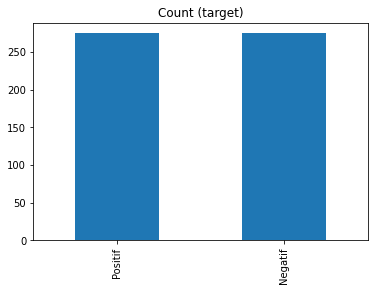

In [ ]:
target_count = df_tweets['label'].value_counts()
target_count.plot(kind='bar', title='Count (target)')
target_count

In [ ]:
X = df_tweets['tweet'].values
y = df_tweets['label'].values

# 14. TF-IDF & Word Visualization
* TF-IDF adalah singkatan dari "Term Frequency – Inverse Document Frequency"
* CountVectorizer: Menghitung setiap jumlah kata/corpus yang muncul dalam kumpulan data tersebut
* Tfidf Transformer: Tranforming untuk perhitungan matriks dari CountVectorizer
* Word Visualization: Menampilkan kata dengan ukuran font berdasarkan pembobotan TF-IDF

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
Train_X_Tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
X_train_counts.shape

(550, 1746)

In [ ]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
token_vocab = df_tweets['tweet_norm2'].apply(word_tokenize_wrapper)
matrix = vectorizer.fit_transform([x for x in np.array(token_vocab)])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 95


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


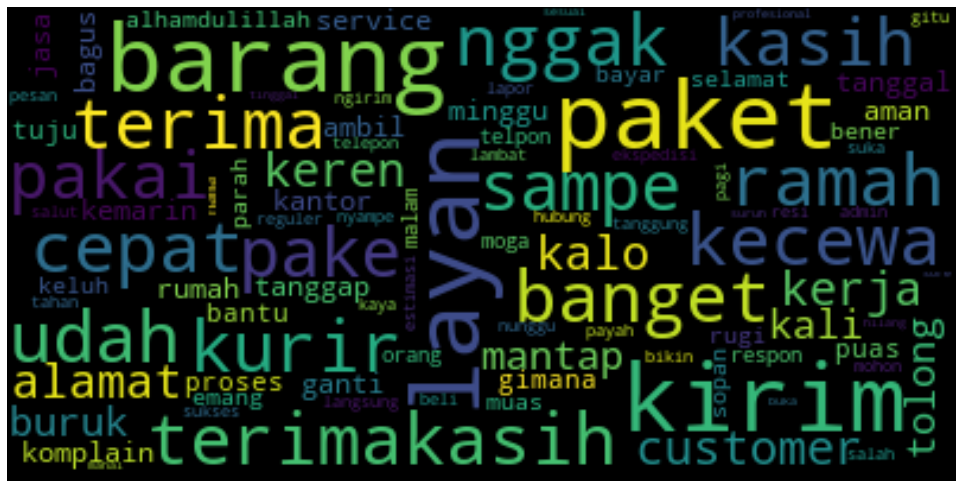

In [ ]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(17, 17))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf2.columns = ['tfidf']    
plot_word_cloud(tfidf2.sort_values(by=['tfidf'], ascending=True))

# 15. Data splitting for 10% data training & 90% data testing 

In [ ]:
train_pct_index = int(0.9 * len(X))
X_train, X_test = Train_X_Tfidf[:train_pct_index], Train_X_Tfidf[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]
X_train, X_test, y_train, y_test = train_test_split(Train_X_Tfidf, y, test_size=0.1)

# 16. Create & fitting model Naive Bayes

In [ ]:
start_time = datetime.now()
mnb = MultinomialNB().fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
end_time = datetime.now()
print("Duration: {}".format(end_time - start_time))

Duration: 0:00:00.005750


# 17. Evaluation

In [ ]:
from sklearn.metrics import f1_score
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))
print("Accuracy %.2f" % (accuracy_score(y_pred2, y_test) * 100 ))

[[30  5]
 [ 0 20]]
              precision    recall  f1-score   support

     Negatif       1.00      0.86      0.92        35
     Positif       0.80      1.00      0.89        20

    accuracy                           0.91        55
   macro avg       0.90      0.93      0.91        55
weighted avg       0.93      0.91      0.91        55

Accuracy 90.91


# 18. Prediction

In [ ]:
test =['Hanya JNE Yang Bisa Membuatku Bahagia #JNE #connectinghappiness #jne30tahun #bahagiabersama',
       'Gw jg kirim dokumen ke singapore tp LOST!!!@leetandud @JNE_ID akun ini d buat untuk layananJNE smakin Tidak bisa dipercaya.',
       'Semakin hari bisnis semakin meninggkat, layananJNE YES. TOP Banget deh JNE !!',
       'Keren layananJNE.... pertahankan dan tingkatkan #LayananJNE',
       'saya komplain ga ditanggapi lagi.. layanan jne tambah parah kualitasnya',
       'Ini kenapa paket saya ga sampai-sampai, padahal statusnya udah diterima, payah',
       'Alhamdulillah dapet potongan harga bayar pake Dana, jadi lebih  murah',
       'Mbak-mbak counternya cuek, judes gitu mukanya #LayananJNE']

predicted = []
for i in test :
    a = count_vect.transform([i])
    X_coba = tfidf_transformer.fit_transform(a).toarray()
    y_pred = mnb.predict(X_coba)
    acc = mnb.predict_proba(X_coba)
    probmnb = acc.max(axis=1)
    pd.options.display.float_format = '{:,.2f}%'.format
    predicted.append({"tweet": i , "label" : y_pred[0], "probability" : probmnb[0]*100})

pd.DataFrame(predicted)

,tweet,label,probability
0,Hanya JNE Yang Bisa Membuatku Bahagia #JNE #connectinghappiness #jne30tahun #bahagiabersama,Positif,65.92%
1,Gw jg kirim dokumen ke singapore tp LOST!!!@leetandud @JNE_ID akun ini d buat untuk layananJNE smakin Tidak bisa dipercaya.,Negatif,64.52%
2,"Semakin hari bisnis semakin meninggkat, layananJNE YES. TOP Banget deh JNE !!",Positif,66.38%
3,Keren layananJNE.... pertahankan dan tingkatkan #LayananJNE,Positif,88.45%
4,saya komplain ga ditanggapi lagi.. layanan jne tambah parah kualitasnya,Negatif,66.61%
5,"Ini kenapa paket saya ga sampai-sampai, padahal statusnya udah diterima, payah",Negatif,77.31%
6,"Alhamdulillah dapet potongan harga bayar pake Dana, jadi lebih murah",Positif,61.30%
7,"Mbak-mbak counternya cuek, judes gitu mukanya #LayananJNE",Negatif,52.43%
